In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/FastAPI Demo"

/content/drive/MyDrive/FastAPI Demo


In [ ]:
from models.unet_model import unet
from models.cnn_model import cnn
from glob import glob
from process.pre_process import resize_image, new_resize_image, split_image, merge_images
import os
import json
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import base64
import numpy as np
import io
import math

In [ ]:
backtest_path = sorted(glob(os.path.join('images', 'Low resolution', "*")))
backtest_path

['images/Low resolution/F1-B1-2h-01.jpeg',
 'images/Low resolution/F1-B1-2h-02.jpeg',
 'images/Low resolution/F1-B1-2h-03.jpeg',
 'images/Low resolution/F1-B1-2h-04.jpeg',
 'images/Low resolution/F1-B1-2h-05.jpeg',
 'images/Low resolution/F1-B1-2h-06.jpeg',
 'images/Low resolution/F1-B1-2h-07.jpeg',
 'images/Low resolution/F1-B1-2h-08.jpeg',
 'images/Low resolution/F1-B1-2h-09.jpeg',
 'images/Low resolution/F1-B1-2h-10.jpeg',
 'images/Low resolution/F1-B1-2h-11.jpeg',
 'images/Low resolution/F1-B1-2h-12.jpeg',
 'images/Low resolution/F1-B1-4h-01.jpeg',
 'images/Low resolution/F1-B1-4h-02.jpeg',
 'images/Low resolution/F1-B1-4h-04.jpeg',
 'images/Low resolution/F1-B1-4h-05.jpeg',
 'images/Low resolution/F1-B1-4h-06.jpeg',
 'images/Low resolution/F1-B1-4h-07.jpeg',
 'images/Low resolution/F1-B1-4h-08.jpeg',
 'images/Low resolution/F1-B1-4h-09.jpeg',
 'images/Low resolution/F1-B1-4h-10.jpeg',
 'images/Low resolution/F1-B1-4h-11.jpeg',
 'images/Low resolution/F1-B1-4h-12.jpeg']

In [ ]:
def cut_unecessary_img(image):
    """
    Crop unnecessary parts of the image and keep only the main object.

    Parameters:
    image (array): The input image to process, in BGR format.

    Returns:
    array: The cropped image or the original image if no suitable contour is found.
    """
    # Check if the image is valid
    if image is None:
        print("Invalid image.")
        return image

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Set the threshold value and threshold the image
    threshold_value = 185
    ret, thresholded_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Invert the thresholded image
    thresholded_image = cv2.bitwise_not(thresholded_image)

    # Find all contours in the thresholded image
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Create a black mask with the same size as the grayscale image
    mask = np.zeros_like(gray_image)

    # Save contours that meet the condition into a list
    new_contours = []

    # Set the minimum height for contours (50% of the image height)
    MIN_HEIGHT = image.shape[1] * 0.5

    # Filter contours with height greater than or equal to MIN_HEIGHT
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if h >= MIN_HEIGHT:
            new_contours.append(cnt)

    # If no suitable contour is found, return the original image
    if not new_contours:
        return image

    # Get the largest contour that meets the condition
    con = new_contours[0]
    x, y, w, h = cv2.boundingRect(con)
    if h < image.shape[0] and w < image.shape[1]:
        # Draw a white contour on the mask
        cv2.drawContours(mask, [con], -1, (255), thickness=cv2.FILLED)

        # Apply the mask to the original image to keep the white contour area
        result = cv2.bitwise_and(image, image, mask=mask)

        # Crop the image
        result = result[y:y+h, x:x+w]

    result = result.astype(np.uint8)
    return result

In [ ]:
images_bt = []
for i in backtest_path:
    img = cv2.imread(i)
    images_bt.append(img)
images_after_process = []
for img in images_bt:
    img = cut_unecessary_img(img)
    images_after_process.append(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def get_contours_max(image):

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Set the threshold value and threshold the image
    threshold_value = 185
    ret, thresholded_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Invert the thresholded image
    thresholded_image = cv2.bitwise_not(thresholded_image)

    # Find all contours in the thresholded image
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Create a black mask with the same size as the grayscale image
    mask = np.zeros_like(gray_image)

    # Save contours that meet the condition into a list
    new_contours = []

    # Set the minimum height for contours (50% of the image height)
    MIN_HEIGHT = image.shape[1] * 0.5

    # Filter contours with height greater than or equal to MIN_HEIGHT
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if h >= MIN_HEIGHT:
            new_contours.append(cnt)

    # If no suitable contour is found, return the original image
    if not new_contours:
        return image

    # Get the largest contour that meets the condition
    con = new_contours[0]
    return con

In [ ]:
contours_max = []
for img in images_after_process:
    con = get_contours_max(img)
    con = con.reshape(-1, 2)
    print(con.shape)
    contours_max.append(con)


(1761, 2)
(1760, 2)
(1827, 2)
(1728, 2)
(1757, 2)
(1767, 2)
(1758, 2)
(1794, 2)
(1766, 2)
(1761, 2)
(1738, 2)
(1767, 2)
(1758, 2)
(1764, 2)
(1788, 2)
(1770, 2)
(1798, 2)
(1754, 2)
(1757, 2)
(1745, 2)
(1724, 2)
(1749, 2)
(1776, 2)


In [ ]:
def predict_mask(image_data):
    try:
        # Decode and preprocess image
        # image = Image.open(io.BytesIO(image_data))
        # image = np.array(image)

        # Perform image processing
        image, con = cut_unecessary_img(image_data)
        image = resize_image(image, image[0][0].tolist())
        image_normalize = image.astype(np.float32) / 255.0

        # Split image into patches
        image_array = split_image(image_normalize)

        # Predict using U-Net model
        predictions = []
        batch_size = 1

        for i in range(0, len(image_array), batch_size):
            batch = np.array(image_array[i:i+batch_size])
            batch_predictions = unet.predict(batch)
            predictions.extend(batch_predictions)

        predictions = np.array(predictions)
        merge_mask = merge_images(image,predictions)
        merge_mask = (merge_mask > 0.5).astype(np.uint8) * 255

        return image, merge_mask, con
    except Exception as e:
        raise RuntimeError(f"Error in image prediction: {e}")

In [ ]:
masks_bt = []
masks_dir = sorted(glob(os.path.join('images', 'saved', "*")))
for i in masks_dir:
    print(i)
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    masks_bt.append(img)

images/saved/F1-B1-2h-01.png
images/saved/F1-B1-2h-02.png
images/saved/F1-B1-2h-03.png
images/saved/F1-B1-2h-04.png
images/saved/F1-B1-2h-05.png
images/saved/F1-B1-2h-06.png
images/saved/F1-B1-2h-07.png
images/saved/F1-B1-2h-08.png
images/saved/F1-B1-2h-09.png
images/saved/F1-B1-2h-10.png
images/saved/F1-B1-2h-11.png
images/saved/F1-B1-2h-12.png
images/saved/F1-B1-4h-01.png
images/saved/F1-B1-4h-02.png
images/saved/F1-B1-4h-04.png
images/saved/F1-B1-4h-05.png
images/saved/F1-B1-4h-06.png
images/saved/F1-B1-4h-07.png
images/saved/F1-B1-4h-08.png
images/saved/F1-B1-4h-09.png
images/saved/F1-B1-4h-10.png
images/saved/F1-B1-4h-11.png
images/saved/F1-B1-4h-12.png


In [ ]:
def draw_contours(image, mask, contours_max):

    MIN_WIDTH = 4
    MAX_HEIGHT = image.shape[1] / 2
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    for cnt in contours:
        in_side = 1
        cnt = np.array(cnt)
        cnt = cnt.reshape(-1,2)
        for point in cnt:
            # Convert point coordinates to the correct data type (tuple of floats)
            point_tuple = (float(point[0]), float(point[1]))
            if(cv2.pointPolygonTest(contours_max, point_tuple, False) < 0):
                in_side = 0
                break
        if in_side == 0:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        if w >= MIN_WIDTH and h < MAX_HEIGHT and h > MIN_WIDTH:
            cv2.drawContours(image, [cnt], -1, (0, 0, 255), 2)

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.show()

In [ ]:
for img, mk, ctm in zip(images_after_process, masks_bt, contours_max):
    draw_contours(img, mk, ctm)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def predict_cell(image,mask, model, contours_max):
    label_dict = {
        0: "abnormal",
        1: "abnormal_2x",
        2: "normal",
        3: "normal_2x"
    }

    ret, nguong1 = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    nguong2 = cv2.bitwise_not(nguong1)

    contours, _ = cv2.findContours(nguong2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    MIN_HEIGHT = 10
    MAX_HEIGHT = image.shape[0] * 0.25

    # bounding_boxes = []
    # contours_list = []
    cell_info = []
    id = 1
    for cnt in contours[:-1]:
        in_side = 1
        cnt = np.array(cnt)
        cnt = cnt.reshape(-1,2)
        for point in cnt:
            point_tuple = (float(point[0]), float(point[1]))
            if(cv2.pointPolygonTest(contours_max, point_tuple, False) < 0):
                in_side = 0
                break
        if in_side == 0:
            continue
        x, y, w, h = cv2.boundingRect(cnt)

        if w > MIN_HEIGHT and w < MAX_HEIGHT and h > MIN_HEIGHT and h < MAX_HEIGHT:
            y1 = max(0, y - 4)
            y2 = min(mask.shape[0], y + h + 4)
            x1 = max(0, x - 4)
            x2 = min(mask.shape[1], x + w + 4)

            crop_number = image[y1:y2, x1:x2]
            crop_number = new_resize_image(crop_number, 64, value = image[0][0].tolist())
            # Dien tich
            area = cv2.contourArea(cnt)
            #   Chu vi
            perimeter = cv2.arcLength(cnt, True)

            #   Circularity
            circularity = 4*math.pi * area / (perimeter*perimeter) if perimeter != 0 else 0

            # Convexity
            hull = cv2.convexHull(cnt)
            convexity = cv2.arcLength(hull, True) / cv2.arcLength(cnt, True)

            # CE Diameter
            CE_diameter = math.sqrt(4 * area / math.pi)

            #  Major/minor axis length
            ellipse = cv2.fitEllipse(cnt)
            major_axis_length = ellipse[1][1]
            minor_axis_length = ellipse[1][0]

            # Aspect Ratio
            aspect_ratio = minor_axis_length / major_axis_length if major_axis_length != 0 else 0

            # Max distance
            max_distance = 0
            for i in range(len(cnt)):
                for j in range(i + 1, len(cnt)):
                    distance = np.linalg.norm(cnt[i][0] - cnt[j][0])
                    max_distance = max(max_distance, distance)
            # print("Max distance: ", max_distance)
            crop_number = crop_number.astype(np.float32) / 255.0
            label = model.predict(np.expand_dims(crop_number, axis=0))
            predicted_class1 = np.argmax(label, axis =1)
            cell_info.append({
                "cell_id" :str(id),
                "x": x,
                "y": y,
                "width": w,
                "height": h,
                "type": label_dict[int(predicted_class1[0])],
                "area": area,
                "perimeter": perimeter,
                "circularity": circularity,
                "convexity": convexity,
                "CE_diameter": CE_diameter,
                "major_axis_length": major_axis_length,
                "minor_axis_length": minor_axis_length,
                "aspect_ratio": aspect_ratio,
                "max_distance": max_distance,
            })
    return cell_info

In [ ]:
backtest_path = sorted(glob(os.path.join('images', 'Low resolution', "*")))
images_name = sorted(os.listdir('images/Low resolution'))
images_bt = []
for i in backtest_path:
    img = cv2.imread(i)
    images_bt.append(img)
images_after_process = []
for img in images_bt:
    img = cut_unecessary_img(img)
    images_after_process.append(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
masks_bt = []
masks_dir = sorted(glob(os.path.join('images', 'saved', "*")))
for i in masks_dir:
    print(i)
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    masks_bt.append(img)
contours_max_bt = []
for img in images_after_process:
    con = get_contours_max(img)
    con = con.reshape(-1, 2)
    print(con.shape)
    contours_max_bt.append(con)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import csv

def save_cell_info_to_csv(cell_info, file_path):
    with open(file_path, mode="w", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=cell_info[0].keys())
        writer.writeheader()
        writer.writerows(cell_info)




In [ ]:
images_name = sorted(os.listdir('images/Low resolution'))
images_name

['F1-B1-2h-01.jpeg',
 'F1-B1-2h-02.jpeg',
 'F1-B1-2h-03.jpeg',
 'F1-B1-2h-04.jpeg',
 'F1-B1-2h-05.jpeg',
 'F1-B1-2h-06.jpeg',
 'F1-B1-2h-07.jpeg',
 'F1-B1-2h-08.jpeg',
 'F1-B1-2h-09.jpeg',
 'F1-B1-2h-10.jpeg',
 'F1-B1-2h-11.jpeg',
 'F1-B1-2h-12.jpeg',
 'F1-B1-4h-01.jpeg',
 'F1-B1-4h-02.jpeg',
 'F1-B1-4h-04.jpeg',
 'F1-B1-4h-05.jpeg',
 'F1-B1-4h-06.jpeg',
 'F1-B1-4h-07.jpeg',
 'F1-B1-4h-08.jpeg',
 'F1-B1-4h-09.jpeg',
 'F1-B1-4h-10.jpeg',
 'F1-B1-4h-11.jpeg',
 'F1-B1-4h-12.jpeg']

In [ ]:
for img, mk, ctm, image_name in zip(images_after_process, masks_bt, contours_max_bt, images_name):
    print(image_name)
    predict_cell(img, mk, cnn, ctm)
    file_path = os.path.join('saved_csv', image_name.split('.')[0] + '.csv')
    save_cell_info_to_csv(predict_cell(img, mk, cnn, ctm), file_path)


F1-B1-2h-01.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/

In [ ]:
print(f"Images: {len(images_after_process)}, Masks: {len(masks_bt)}, Contours: {len(contours_max_bt)}")

Images: 23, Masks: 23, Contours: 23


In [ ]:
model = cnn
i = 1
for img, mk in zip(images_after_process, masks_bt):
    draw_contours(img, mk)
    bounding_boxes, contours_list = predict_cell(img, mk, model)
    print("Image: ", i)
    i += 1
    print("Bounding boxes: ", bounding_boxes)
    print("Contour list: ", contours_list)
    print("\n")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cnt = [1,0]

In [ ]:
import cv2
import numpy as np

# Create a sample contour (a simple square)
contour = np.array([[100, 100], [200, 100], [200, 200], [100, 200]], dtype=np.int32)
contour = contour.reshape((-1, 1, 2))

# Define a few test points
points = [
    (150, 150),  # Inside the square
    (100, 100),  # On the edge of the square
    (50, 50)     # Outside the square
]

# Test each point using cv2.pointPolygonTest
for point in points:
    dist = cv2.pointPolygonTest(contour, point, False)
    print(dist)


1.0
0.0
-1.0


In [ ]:
images_tif = sorted(glob(os.path.join('images','yeastspotter_segs','*.tif')))
images_tif

['images/yeastspotter_segs/F1-B1-2h-01.tif',
 'images/yeastspotter_segs/F1-B1-2h-02.tif',
 'images/yeastspotter_segs/F1-B1-2h-03.tif',
 'images/yeastspotter_segs/F1-B1-2h-04.tif',
 'images/yeastspotter_segs/F1-B1-2h-05.tif',
 'images/yeastspotter_segs/F1-B1-2h-06.tif',
 'images/yeastspotter_segs/F1-B1-2h-07.tif',
 'images/yeastspotter_segs/F1-B1-2h-08.tif',
 'images/yeastspotter_segs/F1-B1-2h-09.tif',
 'images/yeastspotter_segs/F1-B1-2h-10.tif',
 'images/yeastspotter_segs/F1-B1-2h-11.tif',
 'images/yeastspotter_segs/F1-B1-2h-12.tif',
 'images/yeastspotter_segs/F1-B1-4h-01.tif',
 'images/yeastspotter_segs/F1-B1-4h-02.tif',
 'images/yeastspotter_segs/F1-B1-4h-04.tif',
 'images/yeastspotter_segs/F1-B1-4h-05.tif',
 'images/yeastspotter_segs/F1-B1-4h-06.tif',
 'images/yeastspotter_segs/F1-B1-4h-07.tif',
 'images/yeastspotter_segs/F1-B1-4h-08.tif',
 'images/yeastspotter_segs/F1-B1-4h-09.tif',
 'images/yeastspotter_segs/F1-B1-4h-10.tif',
 'images/yeastspotter_segs/F1-B1-4h-11.tif',
 'images/y

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
os.makedirs('images/saved', exist_ok=True)

In [ ]:
images_tif_name = sorted(os.listdir('images/yeastspotter_segs'))
images_tif_name

['F1-B1-2h-01.tif',
 'F1-B1-2h-02.tif',
 'F1-B1-2h-03.tif',
 'F1-B1-2h-04.tif',
 'F1-B1-2h-05.tif',
 'F1-B1-2h-06.tif',
 'F1-B1-2h-07.tif',
 'F1-B1-2h-08.tif',
 'F1-B1-2h-09.tif',
 'F1-B1-2h-10.tif',
 'F1-B1-2h-11.tif',
 'F1-B1-2h-12.tif',
 'F1-B1-4h-01.tif',
 'F1-B1-4h-02.tif',
 'F1-B1-4h-04.tif',
 'F1-B1-4h-05.tif',
 'F1-B1-4h-06.tif',
 'F1-B1-4h-07.tif',
 'F1-B1-4h-08.tif',
 'F1-B1-4h-09.tif',
 'F1-B1-4h-10.tif',
 'F1-B1-4h-11.tif',
 'F1-B1-4h-12.tif']

In [ ]:
for img, img_name in zip(images_tif, images_tif_name):
    img = Image.open(img)
    img = np.array(img)
    plt.imsave(f"images/saved/{img_name.split('.')[0]}.png", img, cmap = "gray")


In [ ]:
save_dir = glob(os.path.join('images', 'saved', "*"))
save_dir

['images/saved/F1-B1-2h-01.png',
 'images/saved/F1-B1-2h-02.png',
 'images/saved/F1-B1-2h-03.png',
 'images/saved/F1-B1-2h-04.png',
 'images/saved/F1-B1-2h-05.png',
 'images/saved/F1-B1-2h-06.png',
 'images/saved/F1-B1-2h-07.png',
 'images/saved/F1-B1-2h-08.png',
 'images/saved/F1-B1-2h-09.png',
 'images/saved/F1-B1-2h-10.png',
 'images/saved/F1-B1-2h-11.png',
 'images/saved/F1-B1-2h-12.png',
 'images/saved/F1-B1-4h-01.png',
 'images/saved/F1-B1-4h-02.png',
 'images/saved/F1-B1-4h-04.png',
 'images/saved/F1-B1-4h-05.png',
 'images/saved/F1-B1-4h-06.png',
 'images/saved/F1-B1-4h-07.png',
 'images/saved/F1-B1-4h-08.png',
 'images/saved/F1-B1-4h-09.png',
 'images/saved/F1-B1-4h-10.png',
 'images/saved/F1-B1-4h-11.png',
 'images/saved/F1-B1-4h-12.png']

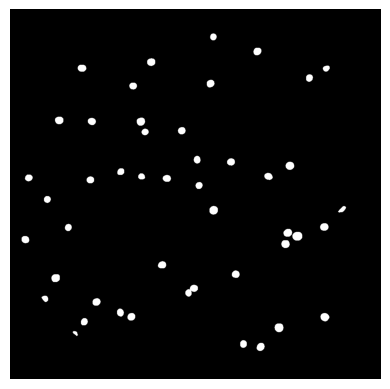

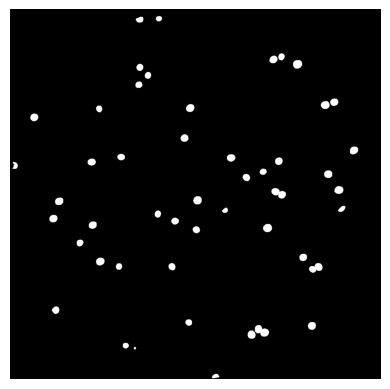

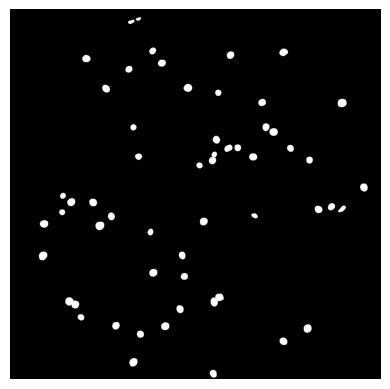

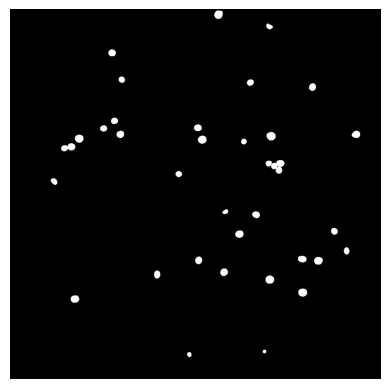

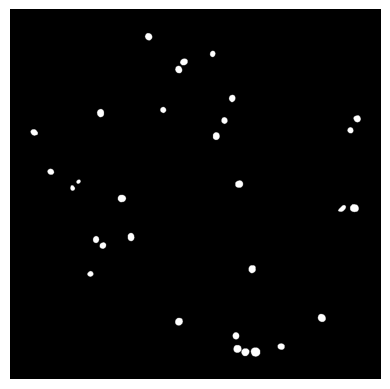

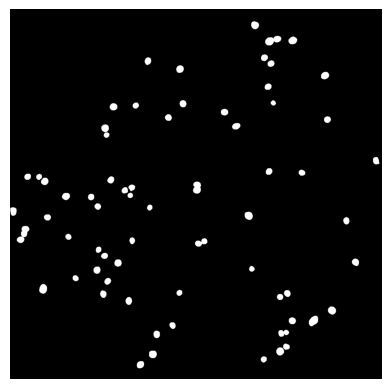

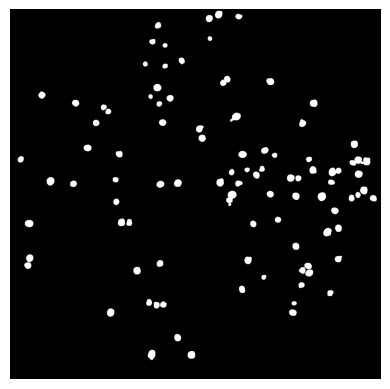

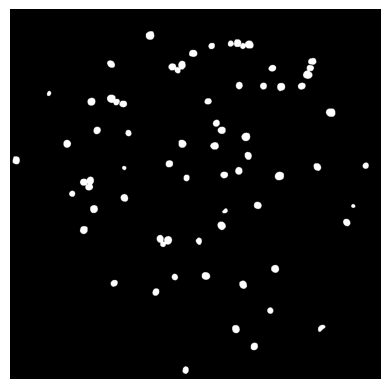

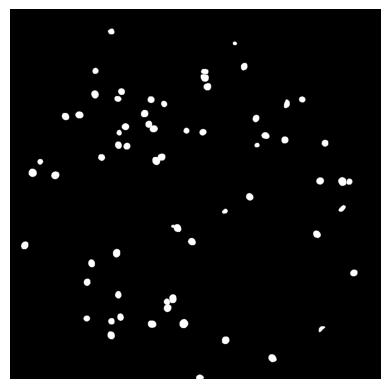

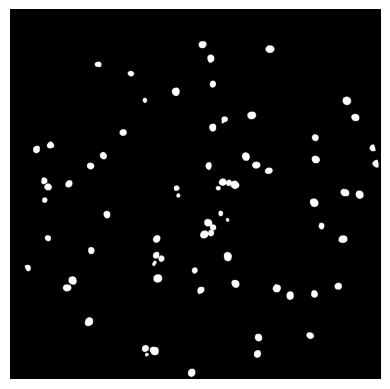

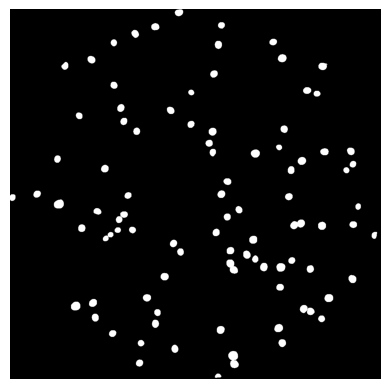

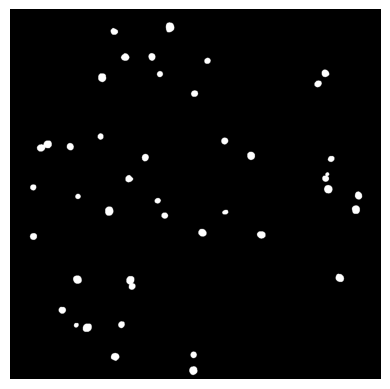

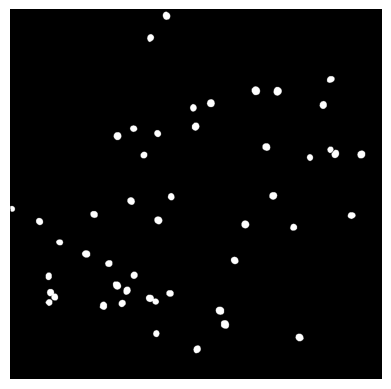

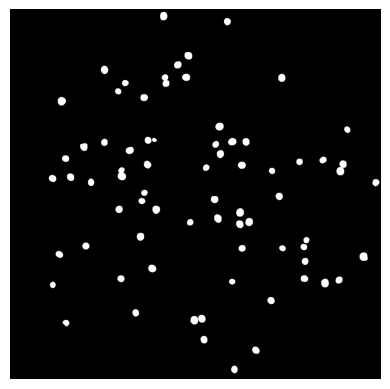

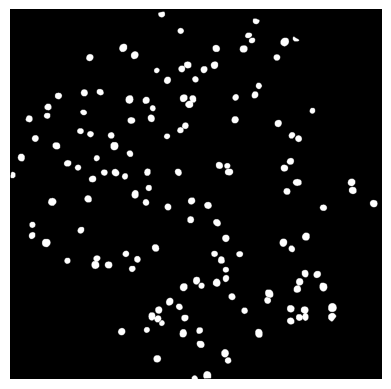

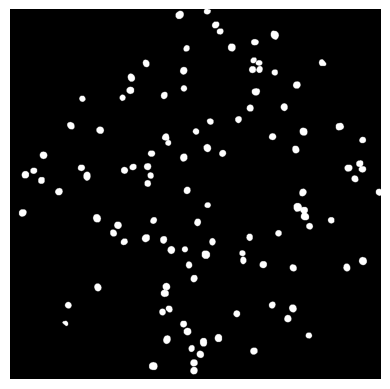

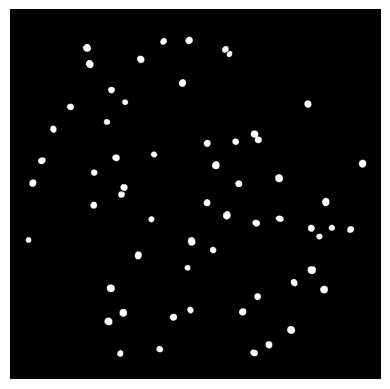

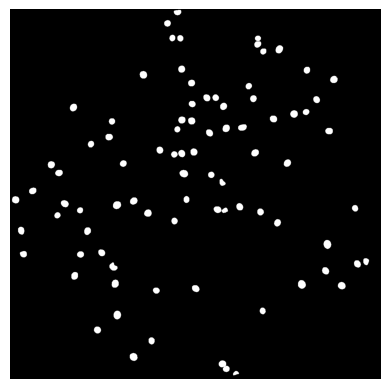

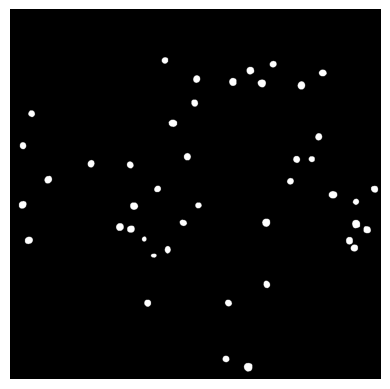

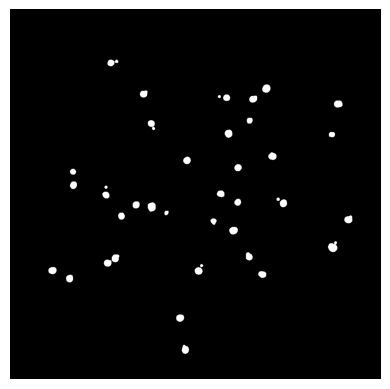

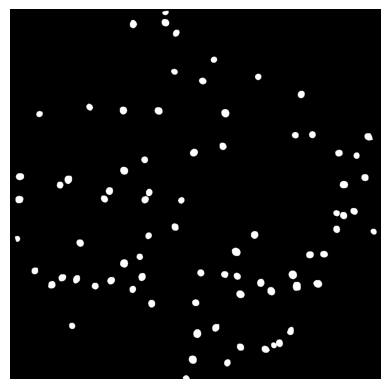

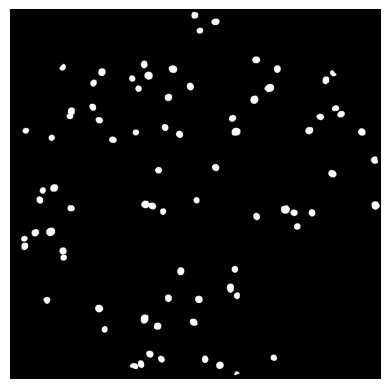

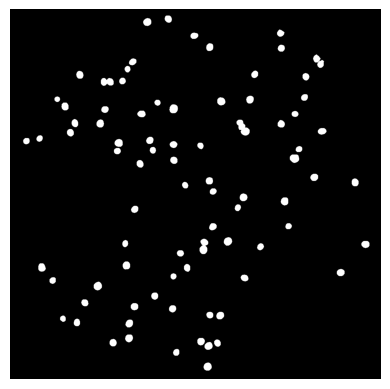

In [ ]:
for i in save_dir:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    threshold = 10
    binary_img = np.where(img < threshold, 0, 255)
    plt.imshow(binary_img, cmap = "gray")
    cv2.imwrite(i, binary_img)
    plt.axis('off')
    plt.show()

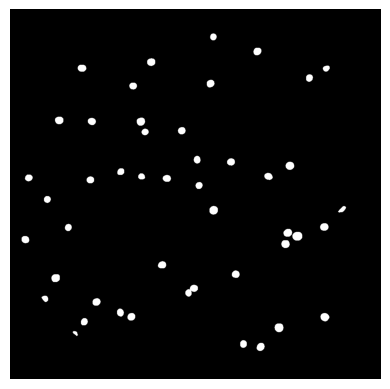

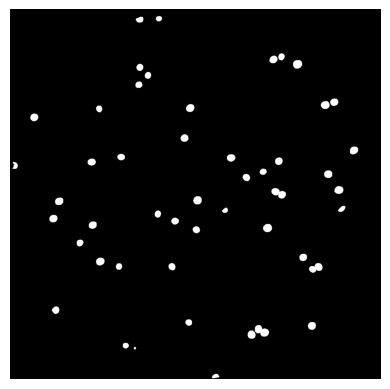

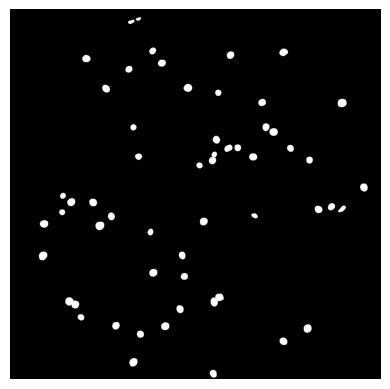

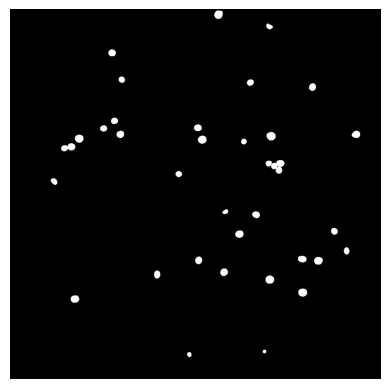

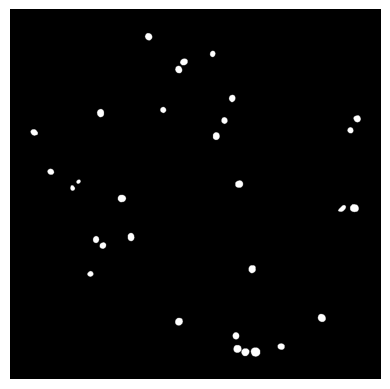

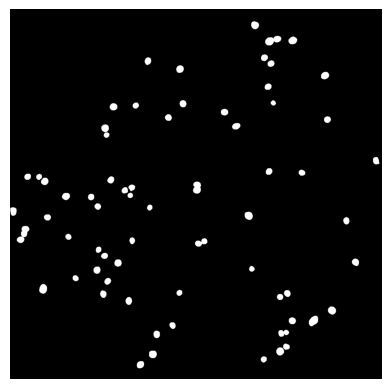

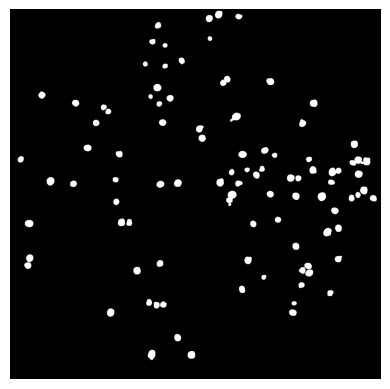

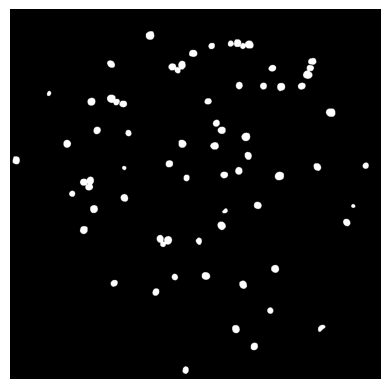

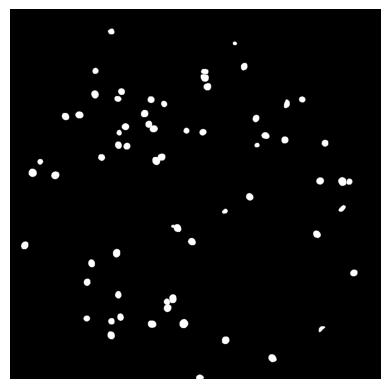

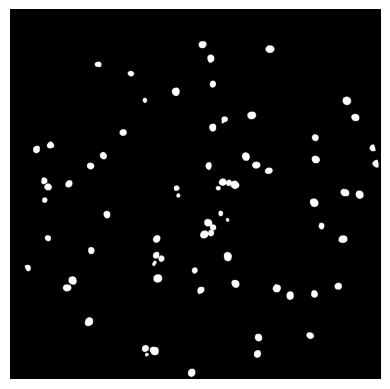

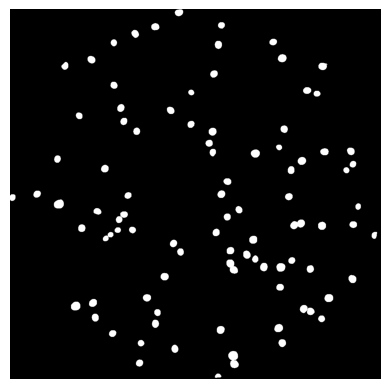

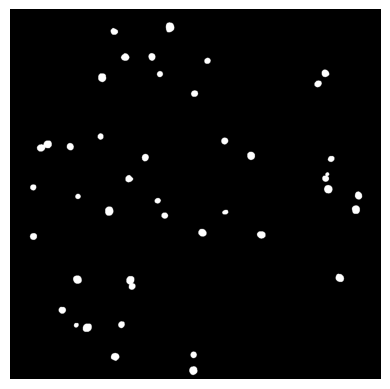

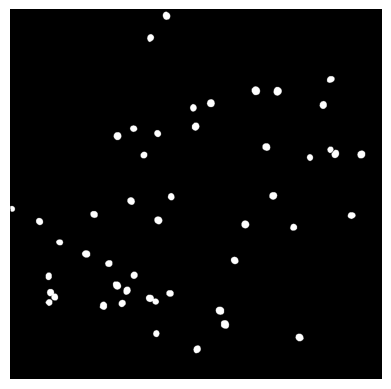

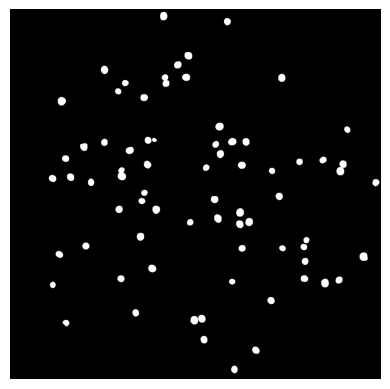

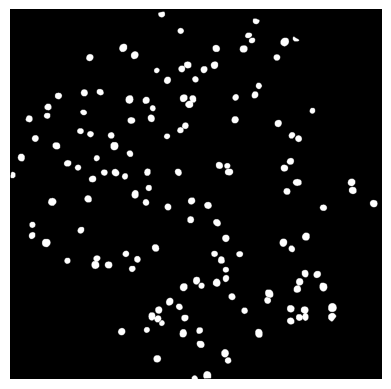

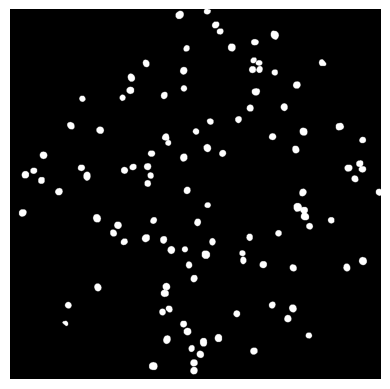

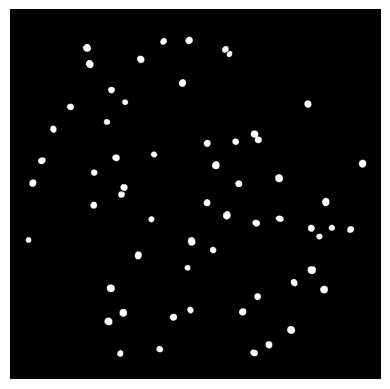

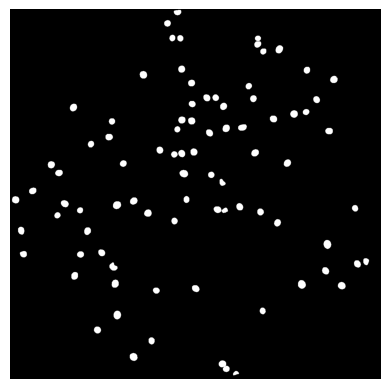

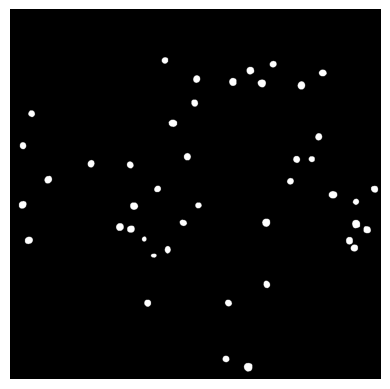

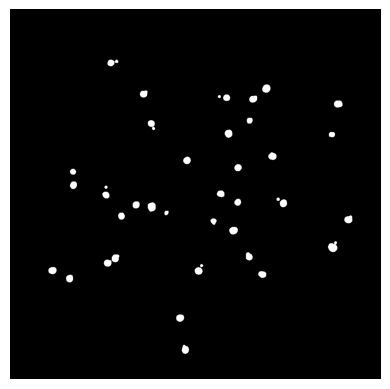

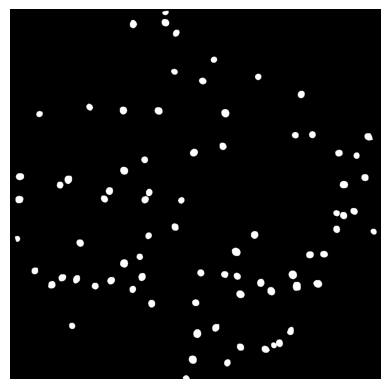

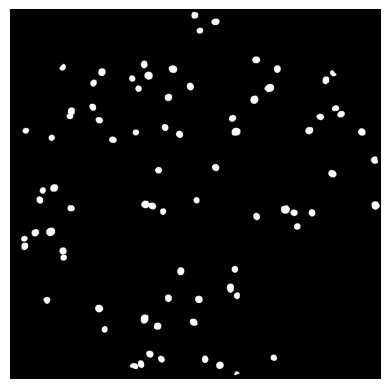

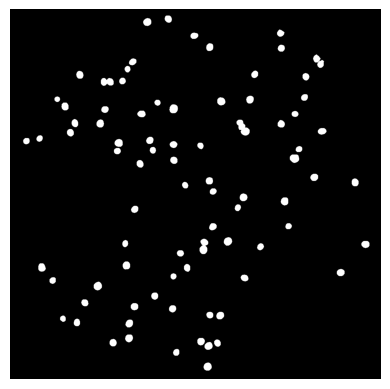

In [ ]:
for i in save_dir:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap = "gray")
    plt.axis('off')
    plt.show()